In [1]:
!pip install -q deeptables[gpu]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids , NearMiss

from tqdm.notebook import tqdm ,tnrange
import deeptables
from deeptables.models.deeptable import DeepTable, ModelConfig
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler , EarlyStopping
import tensorflow as tf
from keras import backend as K

/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/custom.css
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__notebook__.ipynb
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/combined.csv
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__results__.html
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__output__.json
/kaggle/input/healthcareanalyticsii/train.csv
/kaggle/input/healthcareanalyticsii/train_data_dict.csv
/kaggle/input/healthcareanalyticsii/test.csv
/kaggle/input/healthcareanalyticsii/sample_submission.csv


In [3]:
train_data = pd.read_csv('../input/healthcareanalyticsii/train.csv')
test_data = pd.read_csv('../input/healthcareanalyticsii/test.csv')

In [4]:
print(train_data.shape)
train_data.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [5]:
print(test_data.shape)
test_data.head()

(137057, 17)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [6]:
def nullColumns(train_data):
    list_of_nullcolumns =[]
    for column in train_data.columns:
        total= train_data[column].isna().sum()
        try:
            if total !=0:
                print('Total Na values is {0} for column {1}' .format(total, column))
                list_of_nullcolumns.append(column)
        except:
            print(column,"-----",total)
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na


def plotMissingFeature(data_na):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    if(data_na.empty ==False):
        sns.barplot(x=data_na.index, y=data_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)

In [7]:
print('train data')
print(nullColumns(train_data))
print(percentMissingFeature(train_data))
print('\n')
print('test_data')
print(nullColumns(test_data))
print(percentMissingFeature(test_data))

train data
Total Na values is 113 for column Bed Grade
Total Na values is 4532 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.423197
Bed Grade            0.035486
dtype: float64


test_data
Total Na values is 35 for column Bed Grade
Total Na values is 2157 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.573798
Bed Grade            0.025537
dtype: float64


Text(0.5, 1.0, 'Stay')

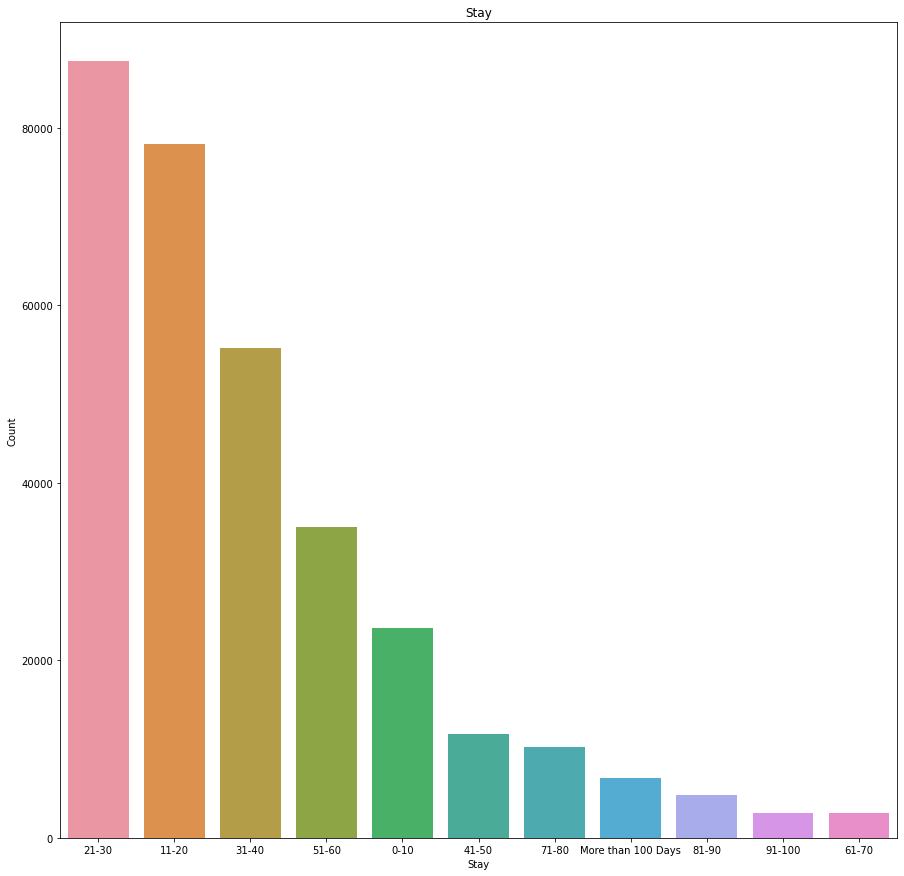

In [8]:
stay = train_data.loc[:,"Stay"].value_counts().rename('Count')
plt.xlabel("Stay")
plt.ylabel('Count')
sns.barplot(stay.index , stay.values).set_title('Stay')

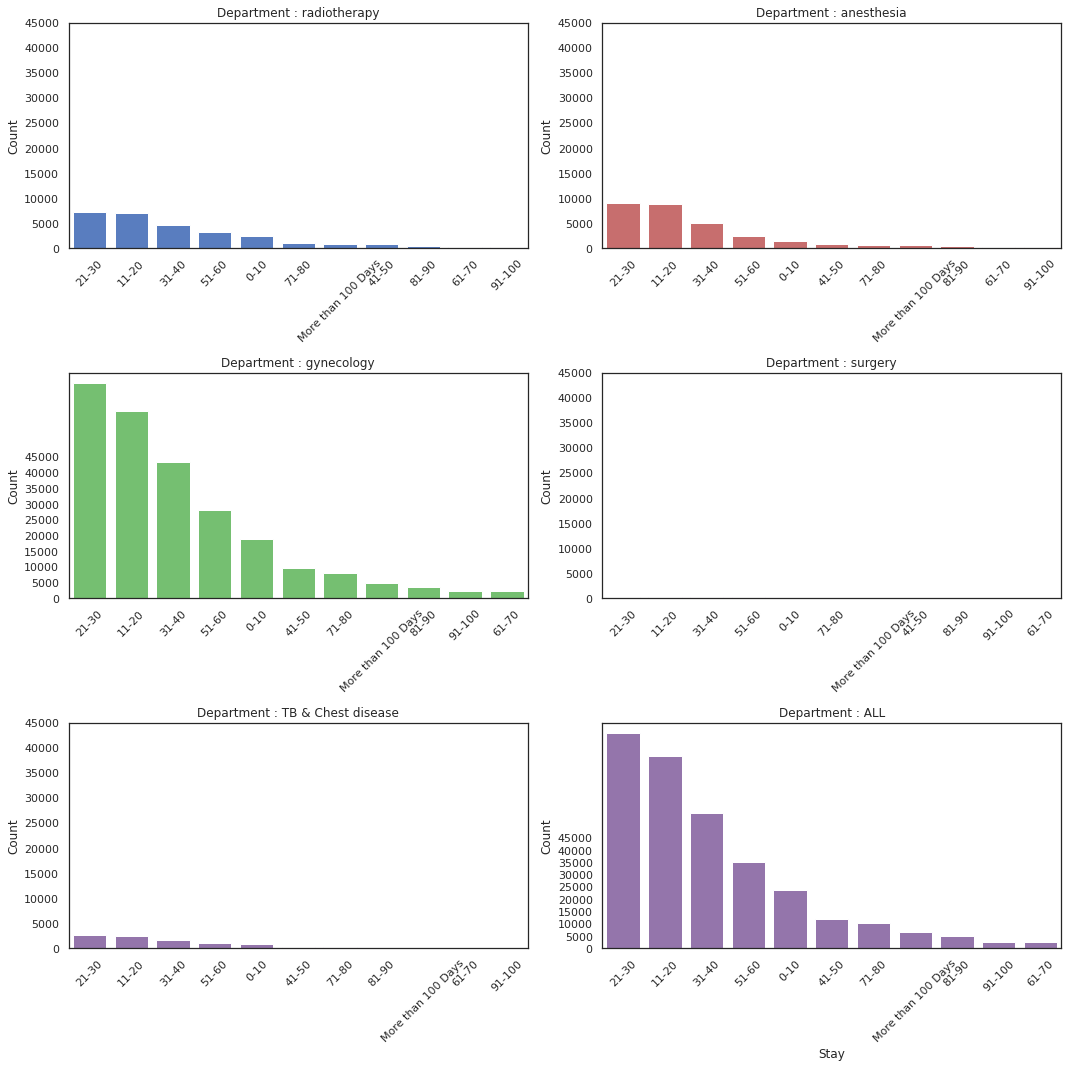

In [9]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 2, figsize=(15, 15))

radiotherapy = train_data[train_data.Department =='radiotherapy']["Stay"].value_counts().rename('Count')

anesthesia = train_data[train_data.Department =='anesthesia']["Stay"].value_counts().rename('Count')

gynecology = train_data[train_data.Department =='gynecology']["Stay"].value_counts().rename('Count')

surgery = train_data[train_data.Department =='surgery']["Stay"].value_counts().rename('Count')

tb = train_data[train_data.Department =='TB & Chest disease']["Stay"].value_counts().rename('Count')

sns.barplot(radiotherapy.index,radiotherapy,  color="b", ax=axes[0, 0]).set_title('Department : radiotherapy')

sns.barplot(anesthesia.index,anesthesia,   color="r", ax=axes[0, 1]).set_title('Department : anesthesia')

sns.barplot(gynecology.index,gynecology,  color="g", ax=axes[1, 0]).set_title('Department : gynecology')

sns.barplot(surgery.index,surgery, color="m", ax=axes[1, 1]).set_title('Department : surgery')

sns.barplot(tb.index,tb, color="m", ax=axes[2, 0]).set_title('Department : TB & Chest disease')

sns.barplot(stay.index,stay, color="m", ax=axes[2, 1]).set_title('Department : ALL')

plt.xlabel("Stay")

plt.setp(axes,yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()


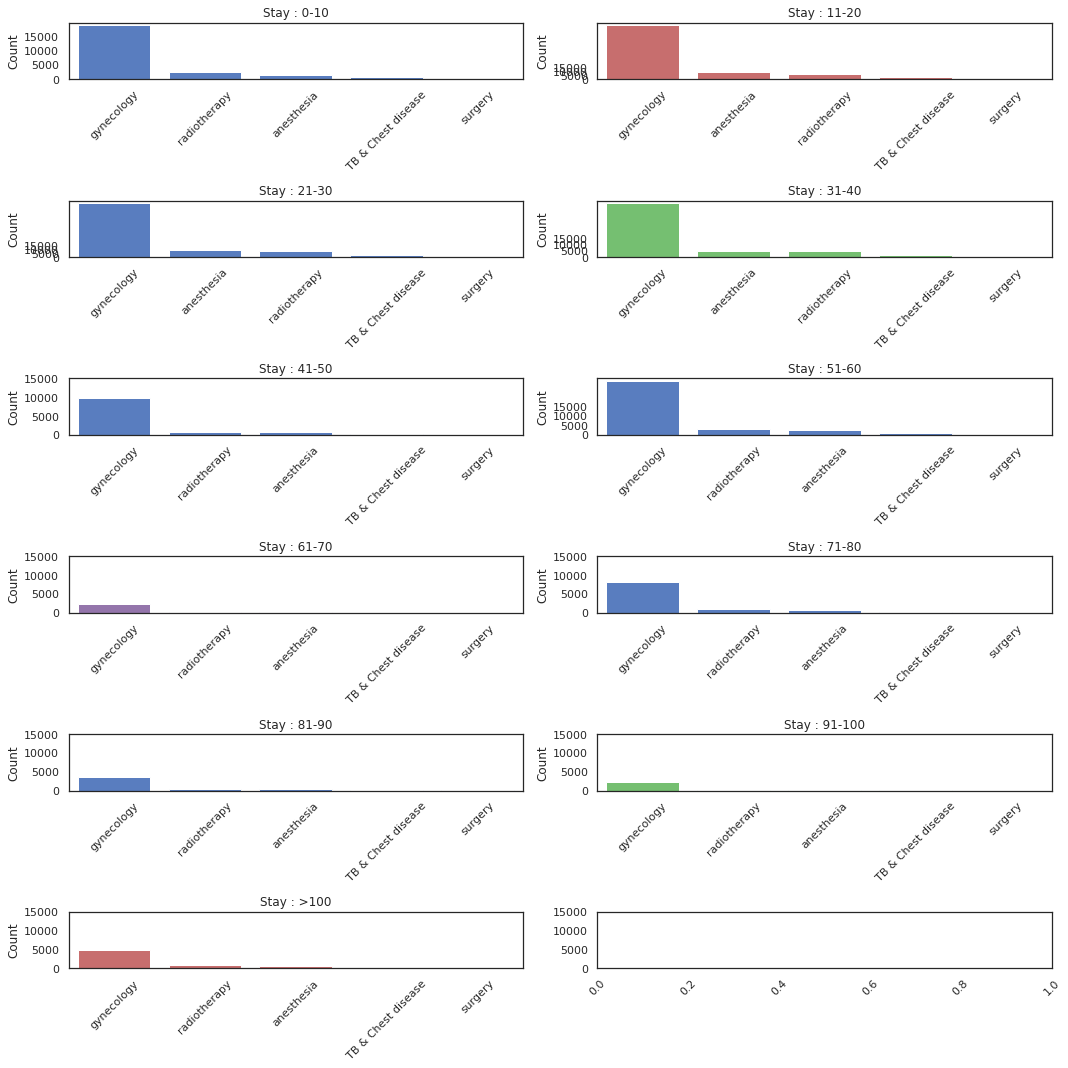

In [10]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(6, 2, figsize=(15, 15))

stay0 = train_data[train_data.Stay =='0-10']["Department"].value_counts().rename('Count')

stay1 = train_data[train_data.Stay =='11-20']["Department"].value_counts().rename('Count')

stay2 = train_data[train_data.Stay =='21-30']["Department"].value_counts().rename('Count')

stay3 = train_data[train_data.Stay =='31-40']["Department"].value_counts().rename('Count')

stay4 = train_data[train_data.Stay =='41-50']["Department"].value_counts().rename('Count')

stay5 = train_data[train_data.Stay =='51-60']["Department"].value_counts().rename('Count')

stay6 = train_data[train_data.Stay =='61-70']["Department"].value_counts().rename('Count')

stay7 = train_data[train_data.Stay =='71-80']["Department"].value_counts().rename('Count')

stay8 = train_data[train_data.Stay =='81-90']["Department"].value_counts().rename('Count')

stay9 = train_data[train_data.Stay =='91-100']["Department"].value_counts().rename('Count')

stay10 = train_data[train_data.Stay =='More than 100 Days']["Department"].value_counts().rename('Count')

sns.barplot(stay0.index,stay0,  color="b", ax=axes[0, 0]).set_title('Stay : 0-10')
                   
sns.barplot(stay1.index,stay2,  color="r", ax=axes[0, 1]).set_title('Stay : 11-20')

sns.barplot(stay2.index,stay2,  color="b", ax=axes[1, 0]).set_title('Stay : 21-30')

sns.barplot(stay3.index,stay3,  color="g", ax=axes[1, 1]).set_title('Stay : 31-40')

sns.barplot(stay4.index,stay4,  color="b", ax=axes[2, 0]).set_title('Stay : 41-50')

sns.barplot(stay5.index,stay5,  color="b", ax=axes[2, 1]).set_title('Stay : 51-60')

sns.barplot(stay6.index,stay6,  color="m", ax=axes[3, 0]).set_title('Stay : 61-70')

sns.barplot(stay7.index,stay7, color="b", ax=axes[3, 1]).set_title('Stay : 71-80')

sns.barplot(stay8.index,stay8,  color="b", ax=axes[4, 0]).set_title('Stay : 81-90')

sns.barplot(stay9.index,stay9,  color="g", ax=axes[4, 1]).set_title('Stay : 91-100')

sns.barplot(stay10.index,stay10, color="r", ax=axes[5, 0]).set_title('Stay : >100')

plt.setp(axes, yticks = np.arange(0,20000,5000))


for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

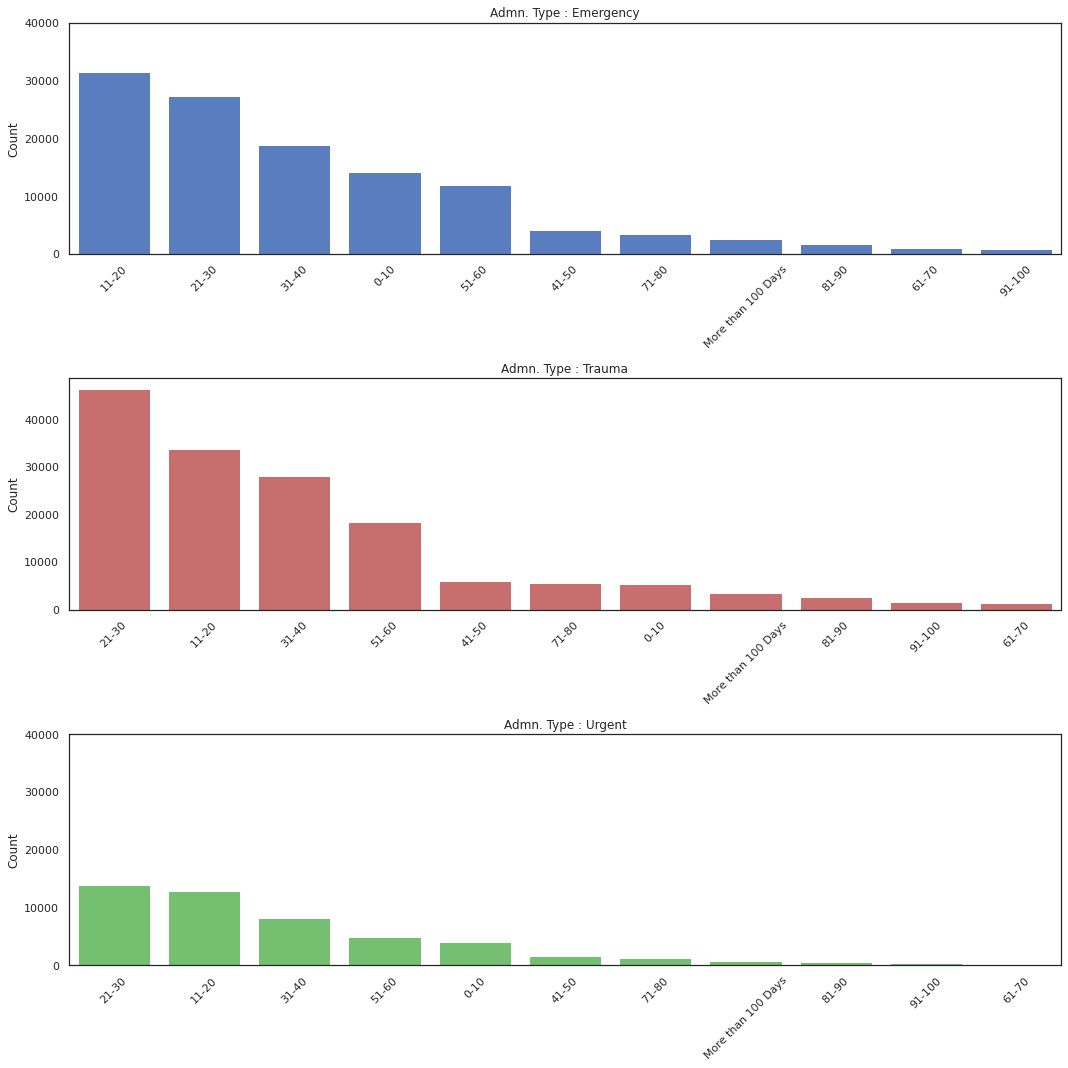

In [11]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(15, 15))

emergency = train_data[train_data['Type of Admission'] =='Emergency']["Stay"].value_counts().rename('Count')

trauma = train_data[train_data['Type of Admission'] =='Trauma']["Stay"].value_counts().rename('Count')

urgent = train_data[train_data['Type of Admission'] =='Urgent']["Stay"].value_counts().rename('Count')

sns.barplot(emergency.index,emergency,  color="b", ax=axes[0]).set_title('Admn. Type : Emergency')

sns.barplot(trauma.index,trauma,   color="r", ax=axes[1]).set_title('Admn. Type : Trauma')

sns.barplot(urgent.index,urgent,  color="g", ax=axes[2]).set_title('Admn. Type : Urgent')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

In [12]:
train_data['City_Code_Patient'] = train_data['City_Code_Patient'].fillna(-1)
train_data['Bed Grade'] = train_data['Bed Grade'].fillna(-1)

In [13]:
test_data['City_Code_Patient'] = test_data['City_Code_Patient'].fillna(-1)
test_data['Bed Grade'] = test_data['Bed Grade'].fillna(-1)

In [14]:
cat_cols = ['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'
            ,'Department','Ward_Type','Ward_Facility_Code','Bed Grade','City_Code_Patient',
           # 'Type of Admission','Severity of Illness',
            'Age']

In [15]:
label = 'Stay'

In [16]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        le = LabelEncoder()
        
        le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
        
        train_df[col] = le.transform(train_df[[col]])
        
        test_df[col] = le.transform(test_df[[col]])

        le_dict[col] = le

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    train_df['Type of Admission'] = train_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    train_df['Severity of Illness'] = train_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    test_df['Type of Admission'] = test_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    test_df['Severity of Illness'] = test_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    return train_df, test_df, le_dict

In [17]:
def feature_importance(model, X_train):

    print(model.feature_importances_)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, model.feature_importances_)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

In [18]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_cols)

In [19]:
#After Feature Engineering
# https://www.kaggle.com/gcspkmdr/lets-get-rid-of-the-patients-feature-engineering

combined_data = pd.read_csv('../input/lets-get-rid-of-the-patients-feature-engineering/combined.csv')

In [20]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [21]:
train_df.drop(columns = ['case_id','train','patientid','Hospital_code',
                         'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

target = train_df.pop('Stay')

test_df.drop(columns = ['case_id','train','Stay','patientid','Hospital_code',
                        'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

In [22]:
cat_features = ['Hospital_region_code','Department','Ward_Type','Bed Grade','City_Code_Patient','Type of Admission','Severity of Illness','Age']

target = target.astype('category') # you have to tell deep table architecture that your target is categorical otherwise it will treat the problem as one of regression

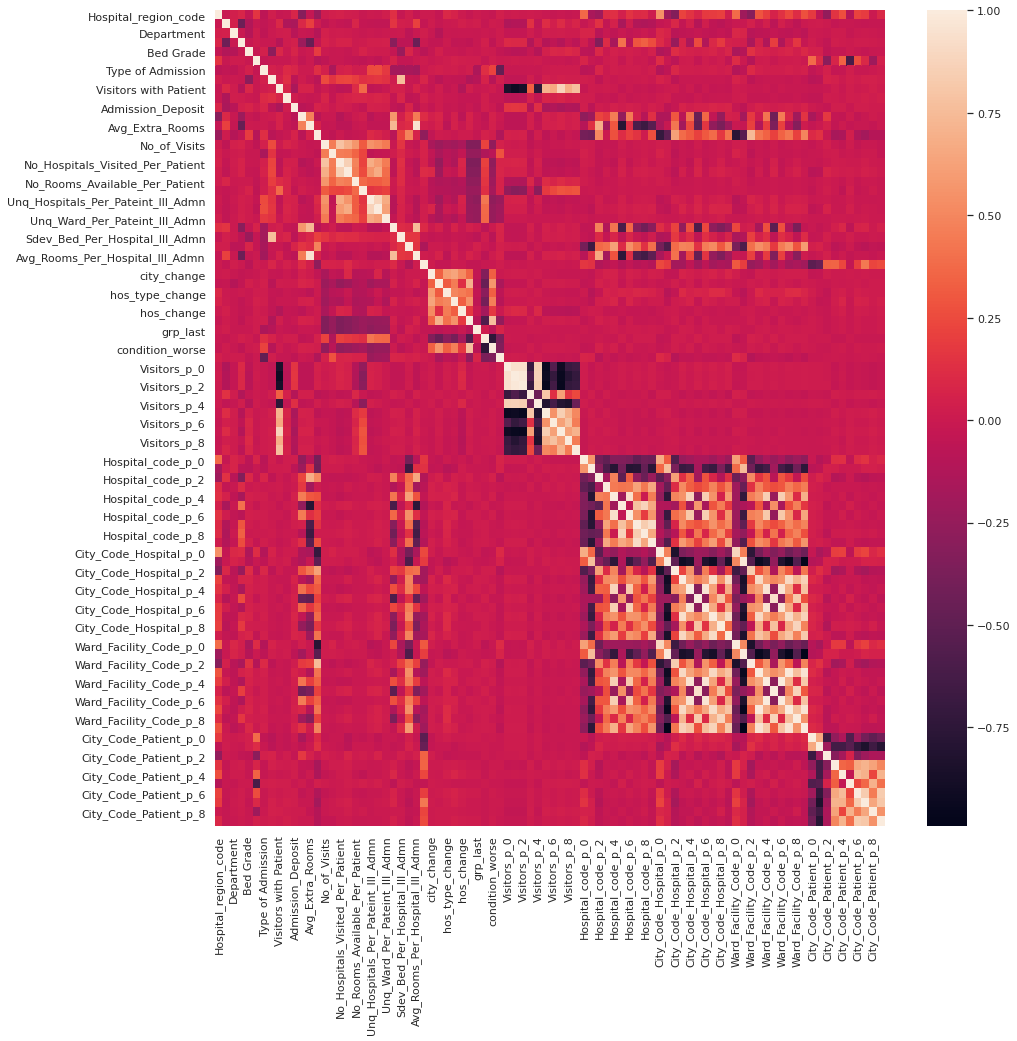

In [23]:
sns.heatmap(train_df.corr())








































# Cross Validation
![](https://4.bp.blogspot.com/-wpr6O3EBAfU/WbHyt6UCOVI/AAAAAAAAjPw/Y1DaO6qcV8oDYjJHzJ1PaPB2EXHmYtBBQCLcBGAs/s1600/%25E6%2593%25B7%25E5%258F%2596.JPG)

* **The CV score generated using the methodology shown in the above figure is a better indicator of model performance than public LB**

In [24]:
# Model Parameters

epochs = 100  #keeping this high as i am using lr scheduler

batch_size = 256

seeds = [32,432 ,73]

#Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience = 5 ,restore_best_weights= True)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x) #for plateau

In [25]:
def build_model():
    
    conf = ModelConfig(dnn_params={'hidden_units':((300, 0.3, True),(300, 0.3, True),), #hidden_units
                                'dnn_activation':'relu',},
                            fixed_embedding_dim=True,
                            embeddings_output_dim=20,
                            nets =['dcn_nets'],
                            stacking_op = 'add',
                            output_use_bias = False,
                            metrics=['accuracy'],
                            categorical_columns = cat_features,
                       home_dir = None
                        )
    dt = DeepTable(config = conf)
    
    return dt

In [26]:
%%time

##DNN

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.45 ,random_state=1)

for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):
    
    K.clear_session()
    
    steps_per_epoch = len(X_train_cv.iloc[idxT])//batch_size
        
    validation_steps = len(X_train_cv.iloc[idxV])//batch_size
    
    print('Fold',i)
    
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    
    dt_cv =  build_model()
    
    model_dnn_cv, history_cv = dt_cv.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                                                 validation_data = (X_train_cv.iloc[idxV],y_train_cv.iloc[idxV]),
                                                 steps_per_epoch = steps_per_epoch,
                                                 validation_steps = validation_steps,
                                                 batch_size=batch_size, epochs=epochs, 
                                                 verbose=0, callbacks=[early_stop,annealer])
    
    val_stats = dt_cv.evaluate(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV], batch_size=batch_size, verbose=0)
    
    acc= val_stats['accuracy']*100
    
    scores.append(acc)
            
    avg_loss.append(val_stats['loss'])
    
    print ('LGB Val CV=',acc)
    
    print('#'*100)
    
    print('\n')
    
print("Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

!rm -rf './dt_output'

Fold 0
 rows of train = 175140 rows of holdout = 143298
11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.1008305549621582
Imputation cost:0.6421666145324707
Categorical encoding cost:0.3941504955291748
fit_transform cost:1.219365119934082
transform_X cost:14.779869794845581
transform_y cost:0.00843048095703125
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
-----------------------------------------

# Model Building

In [27]:
nets = 5

dt = [0] * nets

model_dnn = [0] *nets

history = [0] *nets

seeds = [32 ,432 ,73]

submission = pd.read_csv('../input/healthcareanalyticsii/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),11))

submission_probs = pd.DataFrame(columns = ['case_id'] + list(le_dict['Stay'].classes_))

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [28]:
scores = []

avg_loss = []

submission_name = [] 

X_train_cv,y_train_cv = train_df.copy(), target.copy()

for seed in tnrange(len(seeds)):

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seeds[seed])
    
    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):
        
        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        
        steps_per_epoch = len(X_train_cv.iloc[idxT])//batch_size
        
        validation_steps = len(X_train_cv.iloc[idxV])//batch_size
        
        K.clear_session()
    
        for i in tnrange(nets):

            dt[i] =  build_model()

            model_dnn[i], history[i] = dt[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                                                 validation_data = (X_train_cv.iloc[idxV],y_train_cv.iloc[idxV]),
                                                 steps_per_epoch = steps_per_epoch,
                                                 validation_steps = validation_steps,
                                                 batch_size=batch_size, epochs=epochs, 
                                                 verbose=0, callbacks=[early_stop,annealer])
        
            val_stats = dt[i].evaluate(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV], batch_size=batch_size, verbose=0)
            
            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            submisssion_file_name  = 'submission_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            model_dnn_probs = dt[i].predict_proba(test_df)
            
            submission_probs.iloc[:,1:] = model_dnn_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(model_dnn_probs,axis =1))
            
            # submission file per seed per split per tree
            submission.to_csv(submisssion_file_name,index =False)
        
            probs += model_dnn_probs
            
            acc = val_stats['accuracy']*100
            
            scores.append(acc)
            
            avg_loss.append(val_stats['loss'])
            
            submission_name.append(submisssion_file_name)
            
            print('#'*100)
            
            !rm -rf './dt_output'
            
print("Average Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

!rm -rf './dt_output'

Fold 0
 rows of train = 222906 rows of holdout = 95532


11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.21419334411621094
Imputation cost:0.8303170204162598
Categorical encoding cost:0.5126798152923584
fit_transform cost:1.677180290222168
transform_X cost:10.154468774795532
transform_y cost:0.006008625030517578
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11587119102478027
Imputation cost:0.7726430892944336
Categorical encoding cost:0.4632430076599121
fit_transform cost:1.4514398574829102
transform_X cost:9.54041075706482
transform_y cost:0.006113529205322266
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240)

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11080074310302734
Imputation cost:0.7612457275390625
Categorical encoding cost:0.458545446395874
fit_transform cost:1.4269640445709229
transform_X cost:8.885740518569946
transform_y cost:0.005602359771728516
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240)

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11346030235290527
Imputation cost:0.759756326675415
Categorical encoding cost:0.46627020835876465
fit_transform cost:1.4395310878753662
transform_X cost:8.85373830795288
transform_y cost:0.005381584167480469
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240)

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11314821243286133
Imputation cost:0.763465404510498
Categorical encoding cost:0.4591238498687744
fit_transform cost:1.4321563243865967
transform_X cost:8.879173040390015
transform_y cost:0.0053234100341796875
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

Fold 0
 rows of train = 222906 rows of holdout = 95532


11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11782145500183105
Imputation cost:1.0213794708251953
Categorical encoding cost:0.4806947708129883
fit_transform cost:1.7165651321411133
transform_X cost:8.852198839187622
transform_y cost:0.005480527877807617
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11196088790893555
Imputation cost:0.7612690925598145
Categorical encoding cost:0.49158716201782227
fit_transform cost:1.4604737758636475
transform_X cost:8.866815328598022
transform_y cost:0.005316257476806641
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 24

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11364245414733887
Imputation cost:0.803530216217041
Categorical encoding cost:0.4620246887207031
fit_transform cost:1.4781930446624756
transform_X cost:9.243850469589233
transform_y cost:0.006694316864013672
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240)

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.1143343448638916
Imputation cost:0.8040330410003662
Categorical encoding cost:0.46752381324768066
fit_transform cost:1.4819066524505615
transform_X cost:9.504611015319824
transform_y cost:0.006066799163818359
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11180925369262695
Imputation cost:0.7648789882659912
Categorical encoding cost:0.4622228145599365
fit_transform cost:1.428574800491333
transform_X cost:9.671359777450562
transform_y cost:0.0055387020111083984
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

Fold 0
 rows of train = 222906 rows of holdout = 95532


11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11088752746582031
Imputation cost:0.8441362380981445
Categorical encoding cost:0.45190858840942383
fit_transform cost:1.4916486740112305
transform_X cost:8.782016515731812
transform_y cost:0.0055310726165771484
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 2

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11868786811828613
Imputation cost:0.9337491989135742
Categorical encoding cost:0.45601534843444824
fit_transform cost:1.6027774810791016
transform_X cost:8.793235778808594
transform_y cost:0.005339384078979492
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 24

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11231374740600586
Imputation cost:0.7567446231842041
Categorical encoding cost:0.45383620262145996
fit_transform cost:1.4184463024139404
transform_X cost:8.95594048500061
transform_y cost:0.005524635314941406
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11665129661560059
Imputation cost:0.8781001567840576
Categorical encoding cost:0.45400261878967285
fit_transform cost:1.5444679260253906
transform_X cost:8.846002101898193
transform_y cost:0.00589442253112793
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240

11 class detected, inferred as a [multiclass classification] task
Preparing features cost:0.11121034622192383
Imputation cost:0.7618639469146729
Categorical encoding cost:0.4529595375061035
fit_transform cost:1.4113740921020508
transform_X cost:8.963619947433472
transform_y cost:0.00567936897277832
1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (8)', 'input_continuous_all: (80)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 7, 8, 7, 40, 5, 5, 12]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 240)

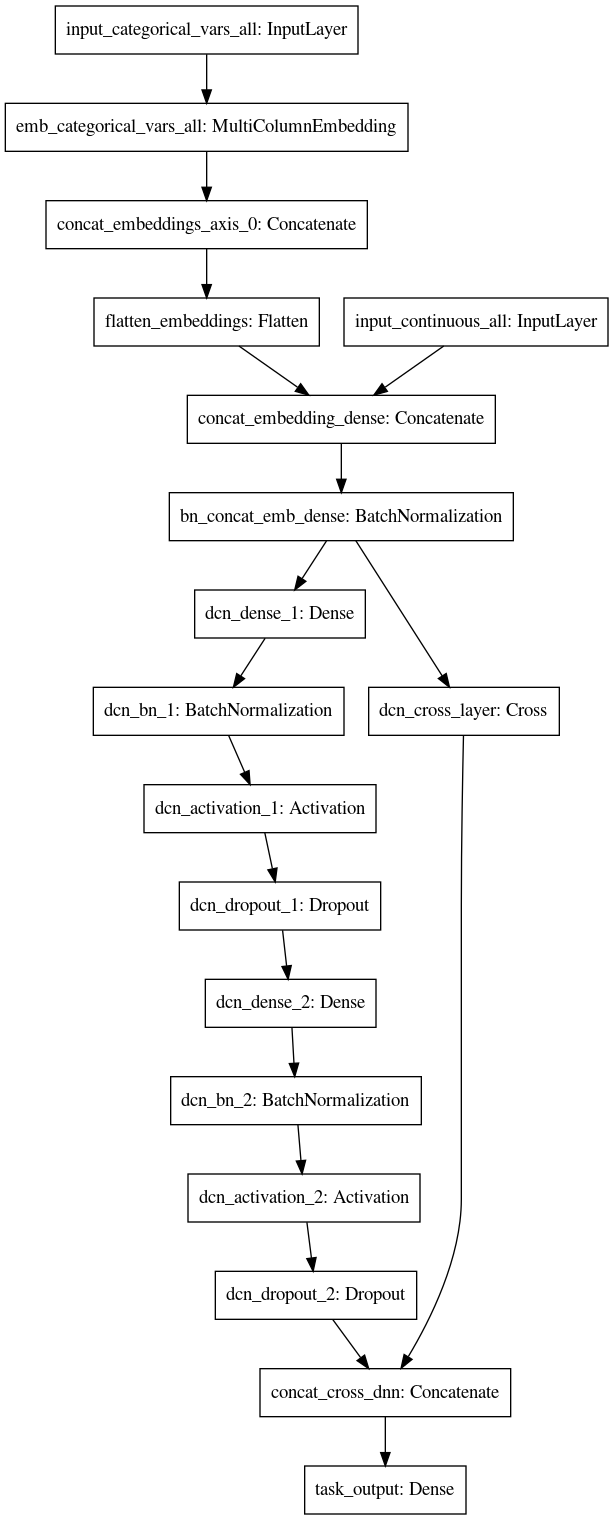

In [29]:
plot_model(dt[0].get_model().model,rankdir='TB')

In [30]:
submission_probs.iloc[:,1:] = probs

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [31]:
submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(probs,axis =1))

# submission file combined            
submission.to_csv('submission.csv',index =False)

submission.head()      

,case_id,Stay
0,318439,0-10
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60


In [32]:
model_stats = pd.DataFrame({'submission':submission_name,'accuracy':scores,'validation_loss':avg_loss})

model_stats.head()

,submission,accuracy,validation_loss
0,submission_32_0_0.csv,43.964326,1.456994
1,submission_32_0_1.csv,43.808356,1.457100
2,submission_32_0_2.csv,43.750784,1.457841
3,submission_32_0_3.csv,43.842900,1.457294
4,submission_32_0_4.csv,43.799984,1.457654


In [33]:
model_stats.to_csv('model_stats.csv',index =False)